In [1]:
import satellite_images_nso.api.nso_georegion as nso
import satellite_images_nso.api.sat_manipulator as sat_manipulator
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from dotenv import load_dotenv
from tools import *
import os

In [2]:
load_dotenv()

user_name = os.getenv('API_USERNAME')
user_password = os.getenv('API_PASSWORD')

# Fetch the geojson file for the region of interest
path_geojson = get_geojson_path('alkmaar.geojson')

# Get the current working directory (useful in Jupyter notebooks)
current_dir = os.getcwd()  # This will give you the current working directory
parent_dir = os.path.join(current_dir, '..')  # Parent directory
folder_data = str(os.path.join(parent_dir, 'data'))  # Point to the 'data' folder

GeoJSON file path: C:\Users\munib\Desktop\Aanbesteding\Project\Project-Digital-Twin\data\alkmaar.geojson


In [3]:
# The first parameter is the path to the geojson, the second the map where the cropped satellite data will be downloaded, the third is your NSO username and the last your NSO password.
georegion = nso.nso_georegion(
    path_to_geojson=path_geojson,
    output_folder=folder_data,
    username=user_name,
    password=user_password,
)


In [4]:
# This method fetches all the download links with all the satellite images the NSO has which contain the region in the given geojson.
# Max_diff parameters represents the amount of percentage the selected region has to be in the satellite image.
# So 1 is the the selected region has to be fully in the satellite images while 0.7 donates only 70% of the selected region is in the
links = georegion.retrieve_download_links(
    max_diff=0.5, start_date="2022-01-01", end_date="2022-04-01"
)

# Inspect the links
print(f"Found links: {len(links)}")
for link in links:
    print(link)

Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.78837337  4.78808248  4.78757723 ...  4.79008716  4.78986092
   4.78837337]
 [52.51916418 52.51919594 52.51925109 ... 52.51923535 52.51923589
  52.51916418]]
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.78837337  4.78808248  4.78757723 ...  4.79008716  4.78986092
   4.78837337]
 [52.51916418 52.51919594 52.51925109 ... 52.51923535 52.51923589
  52.51916418]]
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.78837337  4.78808248  4.78757723 ...  4.79008716  4.78986092
   4.78837337]
 [52.51916418 52.51919594 52.51925109 ... 52.51923535 52.51923589
  52.51916418]]
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.78837337  4.78808248  4.78757723 ...  4.79008716  4.78986092
   4.78837337]
 [52.51916418 52.51919594 52.51925109 ... 52.51923535 52.51923589
  52.51916418]]
Cloudcov

In [5]:
# This example filters out only 200 cm RGB Infrared Superview satellite imagery in the spring from all the links
season = "Spring"
links_group = []
for link in links:
    # Use 200 cm RGB Infrared Superview satellite imagery to get faster download links
    if "SV" in link and "200cm" in link and "RGBI" in link:
        if (
            sat_manipulator.get_season_for_month(
                int(link.split("/")[len(link.split("/")) - 1][4:6])
            )[0]
            == season
        ):
            links_group.append(link)

# Inspect the filtered links
print(f"Found links in the group: {len(links_group)}")
for link in links_group:
    print(link)

Found links in the group: 1
https://api.satellietdataportaal.nl/v1/download/SV_RD_11bit_RGBI_200cm/20220308_103948_SV1-01


In [6]:
# Downloads a satellite image from the NSO, makes a crop out of it so it fits the geojson region and calculates the NVDI index.
# The output will stored in the output folder.
# The parameters are : link, delete_zip_file = False, delete_source_files = True,  plot=True, in_image_cloud_percentage = False,  add_ndvi_band = False, add_height_band = False
# description of these parameters can be found in the code.
georegion.execute_link(links_group[0],  delete_zip_file=True, plot=False, add_ndvi_band=True)

File is already cropped
Ready
Generating NDVI channel...


100%|██████████| 7344/7344 [01:03<00:00, 115.63it/s]


Done with calculating NDVI, saving to: c:/Users/munib/Desktop/Aanbesteding/Project/Project-Digital-Twin/src/../data\20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm_Driehuizen_alkmaar_cropped_ndvi.tif


'c:/Users/munib/Desktop/Aanbesteding/Project/Project-Digital-Twin/src/../data\\20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm_Driehuizen_alkmaar_cropped_ndvi.tif'

Most recent TIFF file: C:\Users\munib\Desktop\Aanbesteding\Project\Project-Digital-Twin\data\20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm_Driehuizen_alkmaar_cropped_ndvi.tif
Number of bands: 5


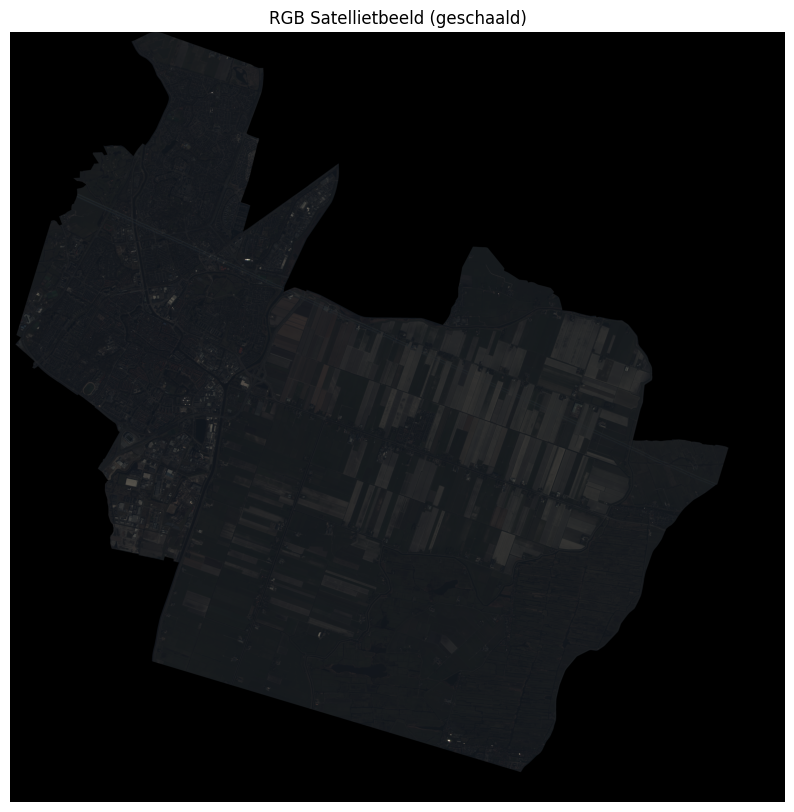

In [7]:
tif_path = get_tif_path()
print(f"Most recent TIFF file: {tif_path}")

# Open the TIFF file and read the bands
with rasterio.open(tif_path) as src:
    red = src.read(3).astype(np.float32)
    green = src.read(2).astype(np.float32)
    blue = src.read(1).astype(np.float32)
    nir= src.read(4).astype(np.float32)

    # Normalize the bands to the range [0, 1]
    max_val = max(red.max(), green.max(), blue.max())
    red /= max_val
    green /= max_val
    blue /= max_val
    nir /= max_val

    # Stack the bands to create an RGB image
    rgb = np.stack((red, green, blue), axis=-1)

    print(f"Number of bands: {src.count}")

# Visualize the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title("RGB Satellietbeeld (geschaald)")
plt.axis("off")
plt.show()

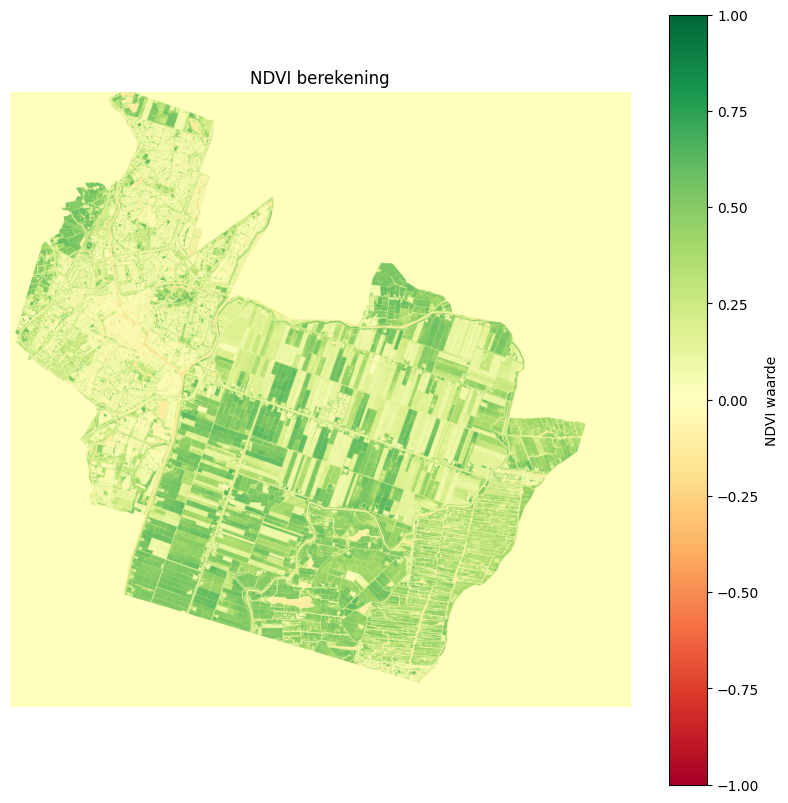

In [8]:
# Calculate NDVI and visualize it
# NDVI = (NIR - Red) / (NIR + Red)
# NIR is the near-infrared band, and Red is the red band.
# The NDVI value ranges from -1 to 1, where higher values indicate healthier vegetation.
ndvi = (nir - red) / (nir + red + 1e-10)  # +1e-10 to avoid division by zero
plt.figure(figsize=(10, 10))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI waarde')
plt.title('NDVI berekening')
plt.axis('off')
plt.show()

In [9]:
from web_export import export_for_web, create_simple_server

bounds_info = export_for_web(tif_path, folder_data, path_geojson)
server_url = create_simple_server(folder_data)
print(f"Server running at: {server_url}")

✅ gdalwarp: Reprojection successful.
Exported images to: c:\Users\munib\Desktop\Aanbesteding\Project\Project-Digital-Twin\src\..\data
Bounds: [[52.55024527689563, 4.707473824344995], [52.6832993389128, 4.927535168652617]]
Image bounds: BoundingBox(left=4.707473824344995, bottom=52.55024527689563, right=4.927535168652617, top=52.6832993389128)
Bounds for Leaflet: [[52.55024527689563, 4.707473824344995], [52.6832993389128, 4.927535168652617]]
❌ Error: c:\Users\munib\Desktop\Aanbesteding\Project\Project-Digital-Twin\src\..\data\index.html not found!
Server running at: None
